# Diffusion Inside a Box
This notebook simulates diffusion of particles bouncing around inside of a box. All functions are defined in the cells below, and then the samples are generated once, loaded, and analyzed.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import pickle
import glob
import pandas as pd

import os

In [2]:
def reflect(val, wall_val):
    # used to bounce off a wall in a box
    return 2*wall_val - val

class Obstacle:
    #convention: walls only have a right side
    left_wall = None
    right_wall = None
    top_wall = None
    bottom_wall = None
    obstacle_type = None

    def __init__(self, lw, rw, tw, bw, obstacle_type):
        self.left_wall = lw
        self.right_wall = rw
        self.top_wall = tw
        self.bottom_wall = bw
        assert (obstacle_type == "wall" or
                obstacle_type == "corner" or
                obstacle_type == "box"), "bad obstacle type"
        self.obstacle_type = obstacle_type
        return None

    def is_outside(self, point):
        x = point[0]
        y = point[1]
        if self.obstacle_type == "wall":
            is_ok_x = (x > self.right_wall)
            return is_ok_x
        elif self.obstacle_type == "corner":
            is_bad_x = (x < self.right_wall)
            is_bad_y = (y < self.top_wall)
            return not (is_bad_x and is_bad_y)
        elif self.obstacle_type == "box":
            is_ok_x = (x < self.right_wall and x > self.left_wall)
            is_ok_y = (y < self.top_wall and y > self.bottom_wall)
            return (is_ok_x and is_ok_y)
        else:
            print("obstacle type not implemented yet")
        return None

    def is_outside2(self, point):
        # true means the move is allowed
        x = point[0]
        y = point[1]
        bounce_x = False
        bounce_y = False
        legal_move = True
        if self.obstacle_type == "wall":
            is_ok_x = (x > self.right_wall)
            legal_move = is_ok_x
            bounce_x = not is_ok_x
        elif self.obstacle_type == "corner":
            is_bad_x = (x < self.right_wall)
            is_bad_y = (y < self.top_wall)
            legal_move = not (is_bad_x and is_bad_y)
            bounce_x = is_bad_x
            bounce_y = is_bad_y
        elif self.obstacle_type == "box":
            is_ok_x = (x < self.right_wall and x > self.left_wall)
            is_ok_y = (y < self.top_wall and y > self.bottom_wall)
            legal_move = (is_ok_x and is_ok_y)
            bounce_x = not is_ok_x
            bounce_y = not is_ok_y
        else:
            print("obstacle type not implemented yet")
        return [legal_move, bounce_x, bounce_y]

    def bounce_box(self, new_position, bounce_x, bounce_y):
        # simulates proper bouncing behavior inside a box
        final_position = new_position
        if bounce_x:
            if new_position[0] < self.left_wall:
                # bouncing off left wall
                reflected_x = reflect(final_position[0], self.left_wall)
            else:
                #bouncing off right wall
                reflected_x = reflect(final_position[0], self.right_wall)
            final_position[0] = reflected_x
        if bounce_y:
            if new_position[1] < self.bottom_wall:
                # bouncing off bottom wall
                reflected_y = reflect(final_position[1], self.bottom_wall)
            else:
                #bouncing off top wall
                reflected_y = reflect(final_position[1], self.top_wall)
            final_position[1] = reflected_y
        return final_position

class Diffusive_particle:
    def __init__(self, x0, y0, z0, rng=0):
        self.x = x0
        self.y = y0
        self.z = y0
        self.xhistory = np.array([x0])
        self.yhistory = np.array([y0])
        self.zhistory = np.array([z0])
        return None

    def time_evolve(self, N, obstacle=None):
        rng = np.random.default_rng()
        phi_values = rng.random(N) * np.pi
        theta_values = rng.random(N) * 2 * np.pi
        for i in range(len(phi_values)):
            xmove = np.cos(theta_values[i])*np.sin(phi_values[i])
            ymove = np.sin(theta_values[i])*np.sin(phi_values[i])
            new_location = [self.x + xmove, self.y + ymove]
            if obstacle==None or obstacle.is_outside(new_location):
                self.x = new_location[0]
                self.y = new_location[1]
            self.xhistory = np.append(self.xhistory, self.x)
            self.yhistory = np.append(self.yhistory, self.y)
            self.zhistory = np.append(self.zhistory, self.z)
        return None

    def time_evolve2(self, N, obstacle=None):
        # only used with box to properly simulate bouncing
        rng = np.random.default_rng()
        phi_values = rng.random(N) * np.pi
        theta_values = rng.random(N) * 2 * np.pi

        for i in range(len(phi_values)):
            xmove = np.cos(theta_values[i])*np.sin(phi_values[i])
            ymove = np.sin(theta_values[i])*np.sin(phi_values[i])
            new_location = [self.x + xmove, self.y + ymove]
            bounce_data = obstacle.is_outside2(new_location)
            bounced_location = obstacle.bounce_box(new_location, bounce_data[1], bounce_data[2])
            self.x = bounced_location[0]
            self.y = bounced_location[1]
            self.xhistory = np.append(self.xhistory, self.x)
            self.yhistory = np.append(self.yhistory, self.y)
            self.zhistory = np.append(self.zhistory, self.z)
        return None

class Particle_collection:
    def __init__(self):
        self.particles = []

    def add_particle(self, particle):
        self.particles.append(particle)

def generate_batch(batchsize, steps, savename, obstacle=None):
    f = open(savename, "wb")
    collection = Particle_collection()
    rng = np.random.default_rng()
    for i in range(batchsize):
        newPoint = Diffusive_particle(0,0,0, rng)
        newPoint.time_evolve(steps, obstacle)
        collection.add_particle(newPoint)
    pickle.dump(collection, f)
    f.close()


def generate_batch_bouncebox(batchsize, steps, savename, obstacle=None):
    # only used with box to properly simulate bouncing
    f = open(savename, "wb")
    collection = Particle_collection()
    rng = np.random.default_rng()
    for i in range(batchsize):
        newPoint = Diffusive_particle(0,0,0, rng)
        newPoint.time_evolve2(steps, obstacle)
        collection.add_particle(newPoint)
    pickle.dump(collection, f)
    f.close()

def load_data_into_N_collections(saveDir, N):
    collection_arr = []
    filenames = np.sort(glob.glob(saveDir + "*"))
    file_count = np.size(filenames)
    lump_size = file_count // N

    start = 0
    end = lump_size
    for i in range(N):
#         print(f"start: {start} and end{end}")
        loop_collection = Particle_collection()
        loop_filenames = filenames[start:end]
        for filename in loop_filenames:
            f = open(filename, "rb")
            temp_collection = pickle.load(f)
            for particle in temp_collection.particles:
                loop_collection.particles.append(particle)
            f.close()
        collection_arr.append(loop_collection)
        start += lump_size
        end += lump_size
    return collection_arr

# generate_basic_diffusion_plot

def plot_particle_collection(ax, collection, time, kwargs):
    xvals = []
    yvals = []

    for particle in collection.particles:
        xvals.append(particle.xhistory[time])
        yvals.append(particle.yhistory[time])

    ax.plot(xvals, yvals, **kwargs)
    return None

def generate_diffusion_plot(collection_arr, times, border_val, kwargs):
    fig, ax = plt.subplots(2,2, sharex=True, sharey=True)
    axes = [(0,0), (0,1), (1,0), (1,1)] # the four axes of the plot
    for big_collection in collection_arr:
        for i in range(4):
            plot_particle_collection(ax[axes[i]], big_collection, times[i], kwargs)
            ax[axes[i]].set_aspect("equal") # make the images square

    if (type(border_val) is list):
        ax[0,0].set_xlim([border_val[0], border_val[1]])
        ax[0,0].set_ylim([border_val[2], border_val[3]])
    else:
        ax[0,0].set_xlim([-1*border_val, border_val])
        ax[0,0].set_ylim([-1*border_val, border_val])

    for i in range(4):
        ax[axes[i]].set_title(f"steps={times[i]}")

    fig.tight_layout()
    ax[axes[0]].set_aspect("equal")
    fig.show()
    return None

def gen_particle_hist_with_errors(collection_arr, left, right, time):
    num_batches = np.size(collection_arr)
    edges = np.arange(left, right+1)- 0.5
    plotting_centers = edges[:-1] + 0.5
    bincount_arr = np.zeros((num_batches, np.size(edges)-1))
    for i in range(num_batches):
        xvals = []
        yvals = []
        for particle in collection_arr[i].particles:
            xvals.append(particle.xhistory[time])
        bincount, _ = np.histogram(xvals, bins=edges, density=True)

        bincount_arr[i, :] = bincount


    # calculate statistics
    bincount_means = np.mean(bincount_arr, axis=0)
    standard_error_of_mean = np.std(bincount_arr, axis=0) / np.sqrt(num_batches)


    return plotting_centers, bincount_means, standard_error_of_mean

def plot_particle_hist_with_errors(collection_arr, left, right, times):
    fig, ax = plt.subplots(1,1)

    for i in range(len(times)):
        kwargs = {
            "marker": ".",
            "ms": 0.5,
            "linewidth": 0.5,
            "label": "t={:d}".format(times[i]),
        }
        plt_cen, binc, stderr = gen_particle_hist_with_errors(collection_arr, left, right, times[i])
        ax.errorbar(plt_cen, binc, yerr = stderr, **kwargs)

    ax.set_ylabel("Probability Density")
    ax.set_xlabel("x-position [step-length]")
    ax.legend()
    fig.show()

In [3]:
# # experimental functions
# def generate_2d_plot(collection_arr, times, border_val, kwargs):
#     fig, ax = plt.subplots(2,2, sharex=True, sharey=True)
#     axes = [(0,0), (0,1), (1,0), (1,1)] # the four axes of the plot

#     time=times[2]

#     num_batches = np.size(collection_arr)
#     xvals = []
#     yvals = []
#     for i in range(num_batches):
#         for particle in collection_arr[i].particles:
#             xvals.append(particle.xhistory[time])
#             yvals.append(particle.yhistory[time])

#     ax[0,0].hist2d(xvals, yvals)

# #     if (type(border_val) is list):
# #         ax[0,0].set_xlim([border_val[0], border_val[1]])
# #         ax[0,0].set_ylim([border_val[2], border_val[3]])
# #     else:
# #         ax[0,0].set_xlim([-1*border_val, border_val])
# #         ax[0,0].set_ylim([-1*border_val, border_val])

# #     for i in range(4):
# #         ax[axes[i]].set_title(f"steps={times[i]}")

# #     fig.tight_layout()
#     fig.show()
#     return None


def gen_particle_hist_with_errors_2d(collection_arr, left, right, time):
    num_batches = np.size(collection_arr)
    edges = np.arange(left, right+1)- 0.5
    plotting_centers = edges[:-1] + 0.5
    bincount_arr = np.zeros((num_batches, np.size(edges)-1, np.size(edges)-1))
#     bincount_arr_y = np.zeros((num_batches, np.size(edges)-1))

    for i in range(num_batches):
        xvals = []
        yvals = []
        for particle in collection_arr[i].particles:
            xvals.append(particle.xhistory[time])
            yvals.append(particle.yhistory[time])
#         print(np.shape(xvals))
        xvals = np.array(xvals)
        yvals = np.array(yvals)
#         print(np.shape(xvals))
#         bincounts, _, _, _ = plt.hist2d(xvals, yvals, bins=edges)
        bincounts, _, _ = np.histogram2d(xvals, yvals, bins=edges, density=True)

        bincount_arr[i, :, :] = bincounts

    # calculate statistics
    bincount_means = np.mean(bincount_arr, axis=0)

    return edges, bincount_means

def plot_particle_hist_with_errors_2d(collection_arr, left, right, times, border_val):
    fig, ax = plt.subplots(2,2)
    axes = [(0,0), (0,1), (1,0), (1,1)]


    for i in range(len(times)):
        kwargs = {
            "marker": ".",
            "ms": 0.5,
            "linewidth": 0.5,
            "label": "t={:d}".format(times[i]),
        }
        edges, bc_means = gen_particle_hist_with_errors_2d(collection_arr, left, right, times[i])
        img = ax[axes[i]].imshow(bc_means, origin="lower", extent=(left, right, left, right), vmax=0.05, cmap='jet')
#         img = ax[axes[i]].imshow(bc_means, origin="lower", extent=(left, right, left, right), norm='symlog', vmax=0.2, cmap='jet')
        plt.colorbar(img, ax=ax[axes[i]])
    ax[axes[i]].set_aspect('equal')


#         print(bc_x)

#     if (type(border_val) is list):
#         ax[0,0].set_xlim([border_val[0], border_val[1]])
#         ax[0,0].set_ylim([border_val[2], border_val[3]])
#     else:
#         ax[0,0].set_xlim([-1*border_val, border_val])
#         ax[0,0].set_ylim([-1*border_val, border_val])

    for i in range(4):
        ax[axes[i]].set_title(f"steps={times[i]}")
        if (type(border_val) is list):
            ax[axes[i]].set_xlim([border_val[0], border_val[1]])
            ax[axes[i]].set_ylim([border_val[2], border_val[3]])
            ax[axes[i]].axis('off')
        else:
            ax[axes[i]].set_xlim([-1*border_val, border_val])
            ax[axes[i]].set_ylim([-1*border_val, border_val])
    fig.tight_layout()
    fig.show()
    return None

## Generate the samples
Will not run unless the necessary directory (particle-data-obstacle-box) is created ahead of time. To generate points for the first time, or regenerate them, change regenerate_points to True, otherwise leave it False.

In [4]:
# cell to simulate multiple particles diffusing
num_particles = 100 # per save file
num_time_steps = 185 # time steps to diffuse
num_save_files = 100 # number of files to save
regenerate_points = True
batch_save_directory = "./particle-data-obstacle-box/"
# box = Obstacle(-8, 8, 4, -4, "box")
box = Obstacle(-1, 9, 7, -1, "box")

if regenerate_points == True:
    os.makedirs(batch_save_directory, exist_ok=True)

    start_point = 0
    end_point = num_save_files

    base_savename = "./particle_data/particle_batch_{:02d}"
    base_savename = batch_save_directory + "particle_batch_{:02d}"



    for num in tqdm(range(start_point, end_point)):
        savename = base_savename.format(num)
        generate_batch(num_particles, num_time_steps, savename, box)

100%|██████████| 100/100 [00:54<00:00,  1.82it/s]


## Load the samples

In [5]:
import time
start_time = time.time()
test_coll = load_data_into_N_collections(batch_save_directory, 5)
print("--- time to load: %s seconds ---" % (time.time() - start_time))

--- time to load: 0.12539291381835938 seconds ---


## Standard x-y position plot
Plots all 10,000 point's x-y positions

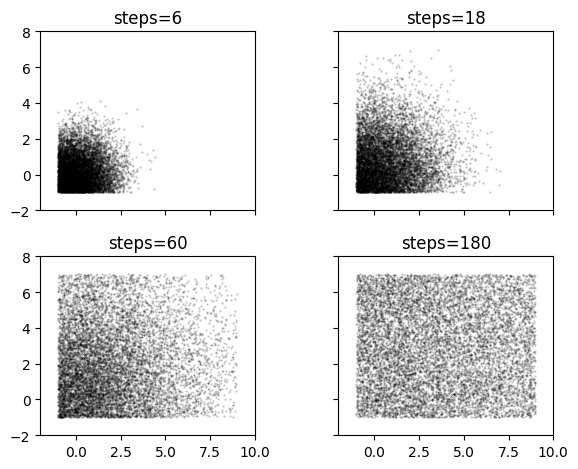

In [6]:
times = [6, 18, 60, 180]
border_val = [-2, 10, -2, 8]
kwargs = {
        "marker": ".",
        "color": "black",
        "alpha": 0.25,
        "linestyle": "none",
        "ms": 1,
    }

generate_diffusion_plot(test_coll, times, border_val, kwargs)

## Histogram of x-position over time
Breaks the 10,000 points into 5 samples of 2,000 each, averages the count in each bin, and calculates error using standard error of the mean, which generates the (pretty small) error bars present on the figure. In the box case, demonstrates the flattening over time, representing the particles spreading out within the box.

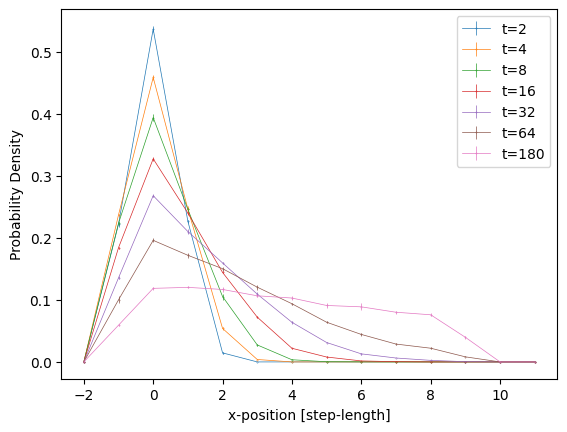

In [7]:
times = [2,4,8,16,32, 64, 180]
plot_particle_hist_with_errors(test_coll, -2, 12, times)

## Averaged Density 2D Histogram plot
A 2D histogram showing probability density over time. Again breaks the data into 5 datasets, and then takes the mean for each bin to be plotted.

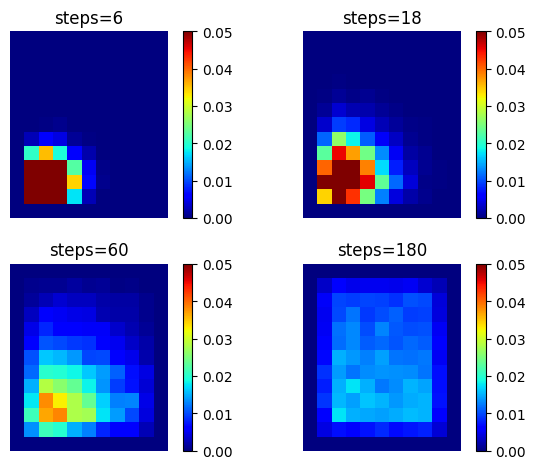

In [8]:
times = [6, 18, 60, 180]
border_val = 20
border_vals = [-2, 9, -2, 11]
plot_particle_hist_with_errors_2d(test_coll, -1*border_val, border_val, times, border_vals)


## Particles Clustering using AI - HDBSCAN
A 2D clustering graph using HDBSCAN showing the particle distribution of each particle cluster. At least 3 clusters are seperated and recognized. The inner-most cluster is defined to be standing cluster, and the outer-most cluster is defined to be expanding cluster.

In order to use this package, we must use the most recent updated version of HDBSCAN, done below, which will uninstall the current version and grab the newer, functional one.

In [9]:
!pip uninstall -y hdbscan
!pip install --upgrade "git+https://github.com/scikit-learn-contrib/hdbscan.git#egg=hdbscan"
from hdbscan import HDBSCAN, approximate_predict

import seaborn as sns

  Cloning https://github.com/scikit-learn-contrib/hdbscan.git to /tmp/pip-install-5qskxz1b/hdbscan_aefa7adf27e447bfbd39f02d0942309b
  Running command git clone --filter=blob:none --quiet https://github.com/scikit-learn-contrib/hdbscan.git /tmp/pip-install-5qskxz1b/hdbscan_aefa7adf27e447bfbd39f02d0942309b
  Resolved https://github.com/scikit-learn-contrib/hdbscan.git to commit e5e1b8e7a348fc06e99d71d35e72d0e51c066194
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for hdbscan: filename=hdbscan-0.8.33-cp310-cp310-linux_x86_64.whl size=3039192 sha256=be0060a71cd1d25509db10350b8c9a9b101d0c4da453271eef81f9bdc50382c2
  Stored in directory: /tmp/pip-ephem-wheel-cache-9w2ddgvy/wheels/dd/9a/ab/564a6c3e58f76c492ab1104d636e794e2fe7b879ba02e344d2
Successfully built hdbscan


In [10]:
def plot_cluster(ax, collection, time, model, kwargs):
    all_pts=[]
    for particle in collection.particles:
      pt_format = [particle.xhistory[time], particle.yhistory[time]]
      all_pts.append(pt_format)
    all_pts = np.array(all_pts)

    db = model.fit(all_pts)

    ax.scatter(all_pts[:, 0], all_pts[:, 1], c=db.labels_, **kwargs)
    return None


def cluster(collection_arr, times, border_val, kwargs):
  fig, ax = plt.subplots(2,2, sharex=True, sharey=True)
  axes = [(0,0), (0,1), (1,0), (1,1)] # the four axes of the plot
  for big_collection in collection_arr:
      for i in range(4):
          model = HDBSCAN(min_cluster_size=3, min_samples=10, cluster_selection_epsilon=0.5, alpha=7.0)
          plot_cluster(ax[axes[i]], big_collection, times[i], model, kwargs)
          ax[axes[i]].set_aspect("equal") # make the images square

  if (type(border_val) is list):
      ax[0,0].set_xlim([border_val[0], border_val[1]])
      ax[0,0].set_ylim([border_val[2], border_val[3]])
  else:
      ax[0,0].set_xlim([-1*border_val, border_val])
      ax[0,0].set_ylim([-1*border_val, border_val])

  for i in range(4):
      ax[axes[i]].set_title(f"steps={times[i]}")

  fig.tight_layout()
  fig.show()
  return None


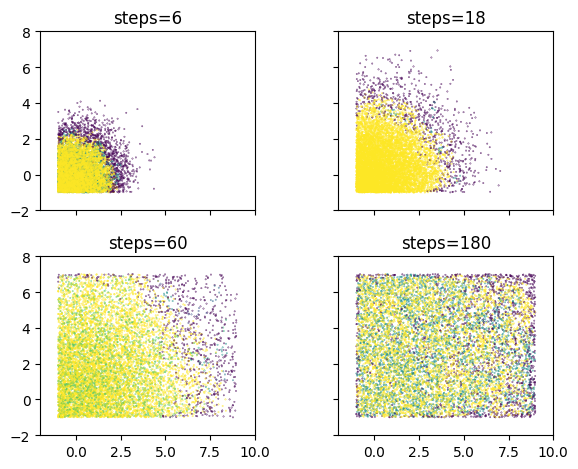

In [11]:
times = [6, 18, 60, 180]
border_val = [-2, 10, -2, 8]
kwargs = {
    "marker": ".",
    "s": 0.3
    }

cluster(test_coll, times, border_val, kwargs)

## Particles Prediction using AI - HDBSCAN
A 2D clustering graph using HDBSCAN showing the particle distribution of each particle cluster. At least 3 clusters are seperated and recognized. The inner-most cluster is defined to be standing cluster, and the outer-most cluster is defined to be expanding cluster.

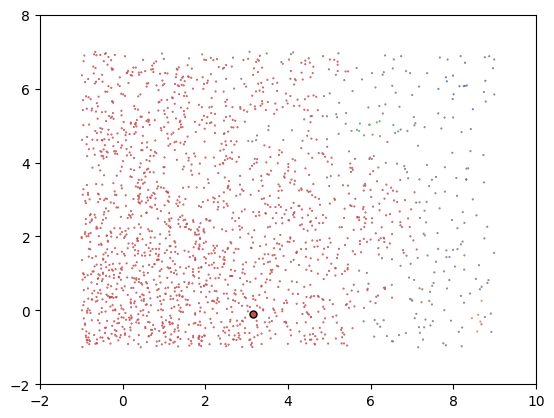

In [12]:
# pal = sns.color_palette('deep', 8) # defined in function so we dont go out of range

def prediction(mid_collection, kwargs, test_kwargs):
  model = HDBSCAN(min_cluster_size=3, min_samples=10, prediction_data=True)
  all_pts=[]
  for particle in mid_collection.particles:
    pt_format = [particle.xhistory[num_time_steps//2], particle.yhistory[num_time_steps//2]]
    all_pts.append(pt_format)
  all_pts = np.array(all_pts)

  db = model.fit(all_pts)

  # manually define colors
#   colors= colors = [sns.desaturate(pal[col], sat) for col, sat in zip(db.labels_, db.probabilities_)]
  cmax = np.max(db.labels_)
  cmin = np.min(db.labels_)
  maxrange = np.max([cmax-cmin, cmax + 1])
  pal = sns.color_palette('deep', maxrange)

  colors = [sns.desaturate(pal[col], sat) for col, sat in zip(db.labels_, db.probabilities_)]

  test_pt = Diffusive_particle(0,0,0, np.random.default_rng())
  test_pt.time_evolve(num_time_steps//2, box)
  test = np.array([test_pt.x, test_pt.y]).reshape(1,2)

  cluster_belong, _ = approximate_predict(model, test)
  test_colors = [pal[col] if col >= 0 else (0.1, 0.1, 0.1) for col in cluster_belong]

  plt.scatter(all_pts[:, 0], all_pts[:, 1], c=colors, **kwargs)
  plt.scatter(test_pt.x, test_pt.y, c=test_colors, **test_kwargs)
  plt.xlim([-2, 10])
  plt.ylim([-2, 8])
  plt.show()

  return db.labels_

kwargs = {
    "marker": ".",
    "s": 1
    }
test_kwargs = {
  "marker": ".",
  "s": 100,
  'edgecolors':'k'
  }

labels = prediction(test_coll[len(test_coll)//2], kwargs, test_kwargs)